# Initial Work

## The Modules

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## The Dataset

In [8]:
df= pd.read_csv('/Users/greysonmeyer/Documents/GitHub/Sumo-Predictions/ultimate_sumo_dataset.csv')

sumo_train, sumo_test = train_test_split(df.copy(),
                                              shuffle=True,
                                              random_state=831,
                                              test_size=.1,
                                              stratify=df.rikishi1_win.values)

interesting_features = ['prev_history', 'rank_difference', 'upset_comparison']

## Deciding Which Features To Use

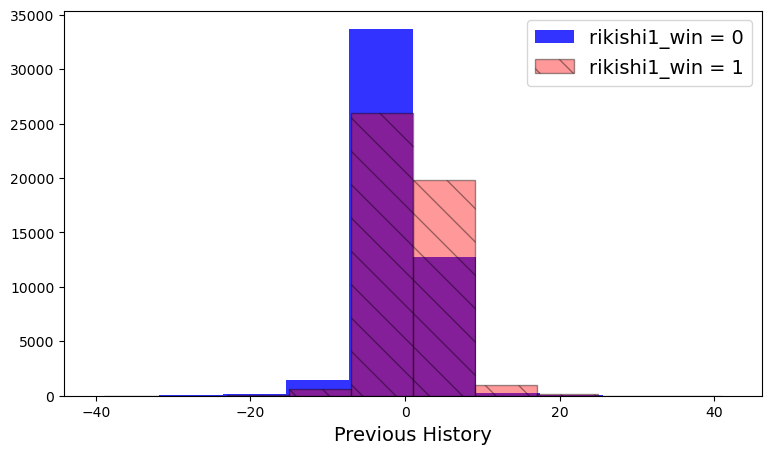

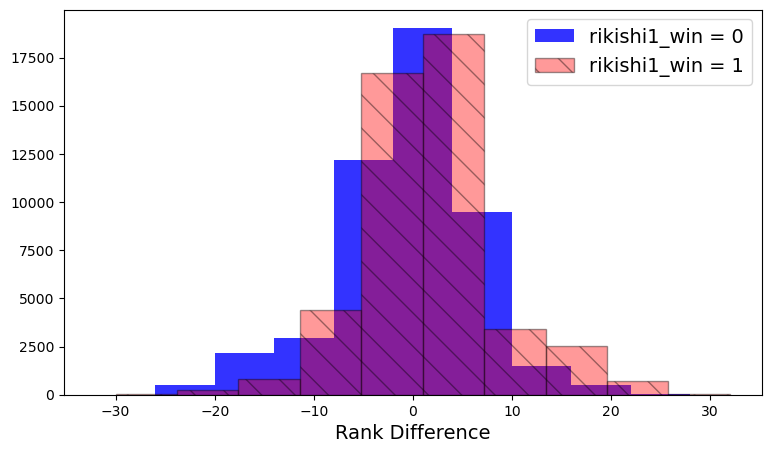

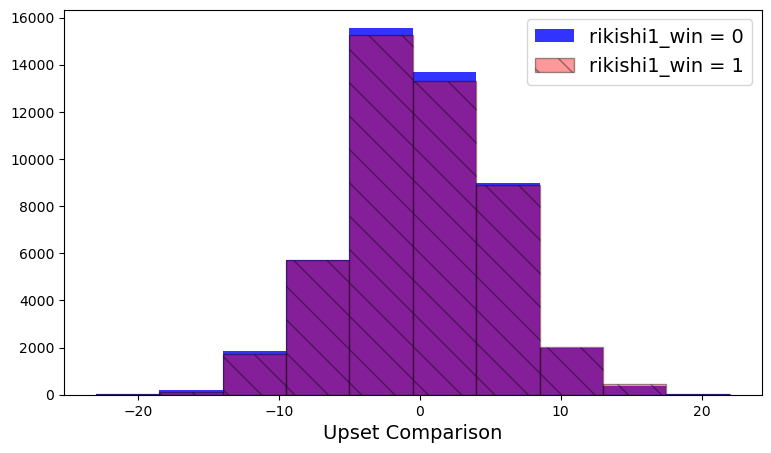

In [3]:
plt.figure(figsize=(9,5))

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history.values,
            color='blue',
            alpha=.8,
            label="rikishi1_win = 0")

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history.values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="rikishi1_win = 1")

plt.xlabel("Previous History", fontsize=14)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(9,5))

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference.values,
            color='blue',
            alpha=.8,
            label="rikishi1_win = 0")

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference.values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="rikishi1_win = 1")

plt.xlabel("Rank Difference", fontsize=14)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(9,5))

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==0].upset_comparison.values,
            color='blue',
            alpha=.8,
            label="rikishi1_win = 0")

plt.hist(sumo_train.loc[sumo_train.rikishi1_win==1].upset_comparison.values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="rikishi1_win = 1")

plt.xlabel("Upset Comparison", fontsize=14)
plt.legend(fontsize=14)

plt.show()

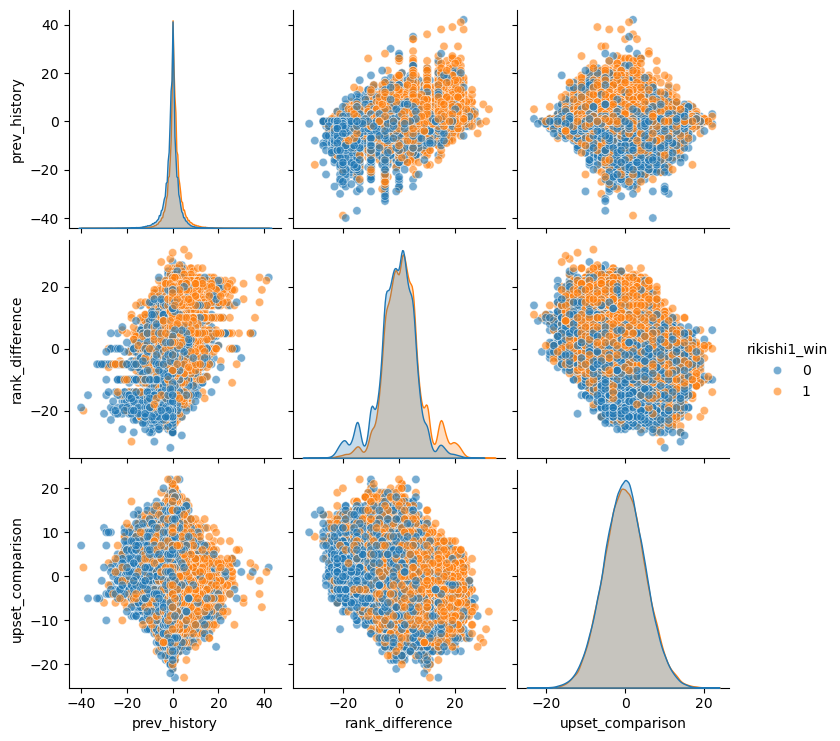

In [4]:
sns.pairplot(data = sumo_train,
                x_vars = ['prev_history', 'rank_difference', 'upset_comparison'],
                y_vars = ['prev_history', 'rank_difference', 'upset_comparison'],
                hue = 'rikishi1_win',
                plot_kws = {'alpha':.6})

plt.show()

In [9]:
# features = ['prev_history', 'rank_difference', 'upset_comparison']
features = ['prev_history', 'rank_difference']

# Models

## Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

### Training

In [6]:
log_reg = LogisticRegression(penalty=None)
log_reg.fit(sumo_train[features], sumo_train.rikishi1_win)
pred = log_reg.predict(sumo_train[features])

NameError: name 'sumo_train' is not defined

### Tuning

In [8]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=831)

In [9]:
log_reg_accs = np.zeros((n_splits, len(features)))

i = 0
for train_index, test_index in kfold.split(sumo_train, sumo_train.rikishi1_win):
    sumo_tt = sumo_train.iloc[train_index]
    sumo_ho = sumo_train.iloc[test_index]
    
    j = 0
    for feature in features:
        log_reg = LogisticRegression(penalty=None)
        log_reg.fit(sumo_tt[feature].values.reshape(-1,1),
                       sumo_tt.rikishi1_win.values)
        
        pred = log_reg.predict(sumo_ho[feature].values.reshape(-1,1))
        
        log_reg_accs[i,j] = accuracy_score(sumo_ho.rikishi1_win.values,
                                              pred)
        
        j = j + 1
    i = i + 1

In [10]:
np.mean(log_reg_accs)

np.float64(0.5659881056375123)

In [11]:
full_log_accs = np.zeros(n_splits)

i = 0
for train_index, test_index in kfold.split(sumo_train, sumo_train.rikishi1_win):
    sumo_tt = sumo_train.iloc[train_index]
    sumo_ho = sumo_train.iloc[test_index]
    
    log_reg = LogisticRegression(penalty=None,
                                     max_iter = 1000)
        
    log_reg.fit(sumo_tt[features].values,
                   sumo_tt.rikishi1_win.values)
        
    pred = log_reg.predict(sumo_ho[features].values)
    
    full_log_accs[i] = accuracy_score(sumo_ho.rikishi1_win.values,
                                              pred)
    
    i = i + 1

In [12]:
np.mean(full_log_accs)

np.float64(0.5723587809484005)

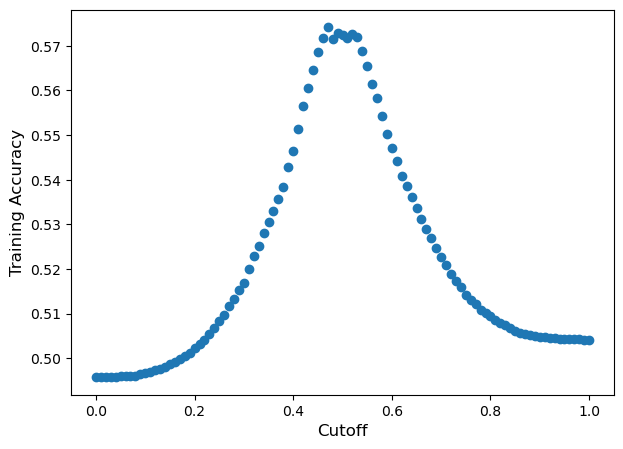

In [13]:
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_prob = log_reg.predict_proba(sumo_train[features].values)[:,1]
    y_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_pred == sumo_train.rikishi1_win.values)/len(sumo_train.rikishi1_win.values))

plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [14]:
best_cutoff = np.argmax(accs)
best_cutoff_acc = accs[best_cutoff]
print("The optimal cutoff was", best_cutoff * 0.01, "which achieved an accuracy of ", best_cutoff_acc)

The optimal cutoff was 0.47000000000000003 which achieved an accuracy of  0.5741715023909488


In [15]:
def logistic_optimal(df, features, y):
    log_reg = LogisticRegression(penalty=None)
    log_reg.fit(df[features], df[[y]])
    y_prob = log_reg.predict_proba(df[features])[:,1]
    y_pred = 1*(y_prob >= .47)
    return y_pred

logistic_optimal(sumo_train, features, 'rikishi1_win')

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 1, ..., 1, 1, 1])

## K-nearest neighbors.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

### Training & Tuning

In [17]:
ks = range(1, 56)

k_all_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(sumo_train, sumo_train.rikishi1_win):
    sumo_tt = sumo_train.iloc[train_index]
    sumo_ho = sumo_train.iloc[test_index]
    
    j = 0
    for k in ks:
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(sumo_tt[features].values,
                   sumo_tt.rikishi1_win.values)
        
        pred = knn.predict(sumo_ho[features].values)
        
        k_all_accs[i,j] = accuracy_score(sumo_ho.rikishi1_win.values, pred)
        
        j = j + 1
    i = i + 1

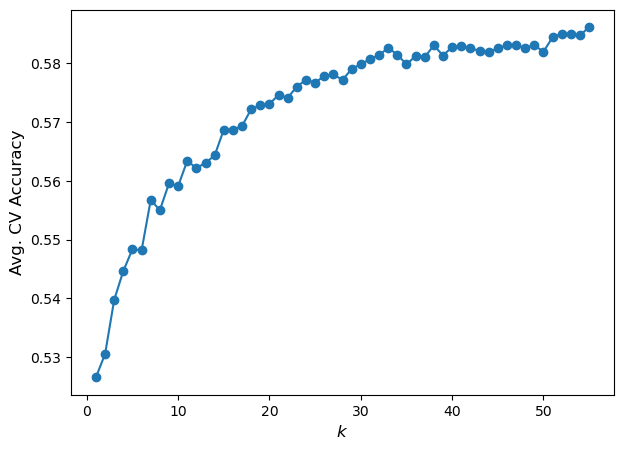

In [18]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

The tiniest bit better.

In [19]:
best_k = np.argmax(np.mean(k_all_accs, axis=0))
best_k_acc = np.mean(k_all_accs, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

The optimal value of k was 55 which achieved a mean CV accuracy of  0.5861731534985268


In [20]:
knn_pipe = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(55))]) 
knn_pipe.fit(sumo_train[features].values, sumo_train.rikishi1_win.values)
knn_pipe.predict_proba(sumo_train[features])

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0.52727273, 0.47272727],
       [0.54545455, 0.45454545],
       [0.38181818, 0.61818182],
       ...,
       [0.63636364, 0.36363636],
       [0.34545455, 0.65454545],
       [0.36363636, 0.63636364]])

In [21]:
confusion_matrix(sumo_train.rikishi1_win, knn_pipe.predict(sumo_train[features].values))

array([[30257, 18142],
       [21421, 26167]])

In [22]:
print("The training recall is",
         np.round(recall_score(sumo_train.rikishi1_win, knn_pipe.predict(sumo_train[features].values)),4))

print("The training precision is",
         np.round(precision_score(sumo_train.rikishi1_win, knn_pipe.predict(sumo_train[features].values)),4))

The training recall is 0.5499
The training precision is 0.5906


In [23]:
fprs, tprs, cutoffs = roc_curve(sumo_train.rikishi1_win, knn_pipe.predict_proba(sumo_train[features])[:,0])

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


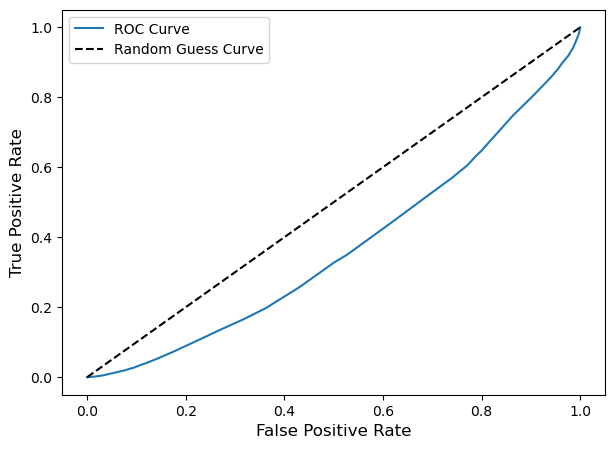

In [24]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

In [25]:
roc_auc_score(sumo_train.rikishi1_win, knn_pipe.predict_proba(sumo_train[features])[:,0])

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


np.float64(0.3697611300945456)

## Linear Discriminant Analysis

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
LDA = LinearDiscriminantAnalysis(store_covariance = True)
LDA.fit(sumo_train[features].values, sumo_train.rikishi1_win)

LinearDiscriminantAnalysis(store_covariance=True)

In [28]:
LDA.predict_proba(sumo_train[features].values)

array([[0.54359869, 0.45640131],
       [0.57914605, 0.42085395],
       [0.47281226, 0.52718774],
       ...,
       [0.50625644, 0.49374356],
       [0.51158169, 0.48841831],
       [0.52362022, 0.47637978]])

## Quadratic Discriminant Analysis

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [30]:
QDA = QuadraticDiscriminantAnalysis(store_covariance = True)

In [31]:
QDA.fit(sumo_train[features].values,
               sumo_train.rikishi1_win)

QuadraticDiscriminantAnalysis(store_covariance=True)

## Gaussian Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [33]:
nb = GaussianNB()
nb.fit(sumo_train[features].values,
          sumo_train.rikishi1_win)

GaussianNB()

In [34]:
param_grid = {'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-6]}
grid = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid.fit(sumo_train[features], sumo_train.rikishi1_win)
print("Best parameters:", grid.best_params_)

Best parameters: {'var_smoothing': 1e-12}


## Linear Support Vector Classifier

In [35]:
from sklearn.svm import LinearSVC
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [36]:
param_dist = {
    'C': uniform(0.01, 10),  # Randomly sample C between 0.01 and 10
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False]
}

model = LinearSVC(max_iter=1000)
random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)

print("Best parameters:", random_search.best_params_)

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Best parameters: {'C': np.float64(2.0067378215835974), 'dual': True, 'loss': 'squared_hinge'}


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
svc = LinearSVC(C=7.33, max_iter=1000, dual = True)

svc.fit(sumo_train[features], sumo_train.rikishi1_win)

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=7.33, dual=True)

## SVC

In [38]:
from sklearn.svm import SVC

In [39]:
param_dist = {
    'C': uniform(0.1, 100),  # Sample C between 0.1 and 100
    'gamma': uniform(0.001, 1),  # Sample gamma between 0.001 and 1
    'kernel': ['rbf']
}
random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=20, cv=3, n_jobs=-1, random_state=42)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)
print("Best parameters:", random_search.best_params_)

Best parameters: {'C': np.float64(30.56137691733707), 'gamma': np.float64(0.09867211400638387), 'kernel': 'rbf'}


In [40]:
svc_poly = SVC(kernel='poly', degree=2, C=10)

## one with rbf kernel, C = 10
svc_rbf = SVC(kernel = 'rbf', C=10)


## fit a model
svc_poly.fit(sumo_train[features], sumo_train.rikishi1_win)
svc_rbf.fit(sumo_train[features], sumo_train.rikishi1_win)

SVC(C=10)

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


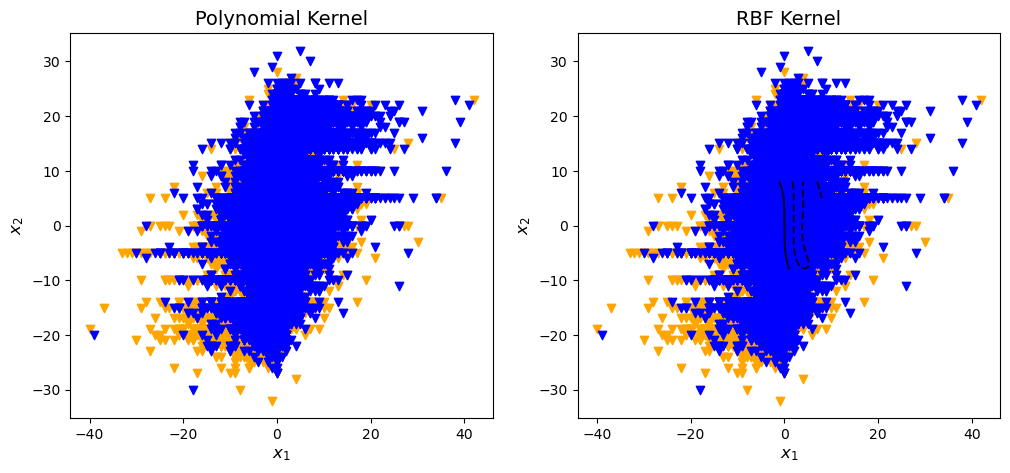

In [45]:
# get a grid of x1 values
x1x1 = np.linspace(-8, 8, 100)

# get a grid of x2 values
x2x2 = np.linspace(-8, 8, 100)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

# get the value of the decision function for this grid
Z_poly = svc_poly.decision_function(x1x2).reshape(X1X1.shape)
Z_rbf = svc_rbf.decision_function(x1x2).reshape(X1X1.shape)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot on the first subplot
ax[0].scatter(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history, 
              sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference, 
              c='orange', 
              marker='v',
              label="0")

ax[0].scatter(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history, 
              sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference, 
              c='blue', 
              marker='v',
              label="1")

# Polynomial Kernel Contour
ax[0].contour(X1X1, X2X2, Z_poly,
              colors='k', levels=[0,1], 
              alpha=.8, linestyles=['-','--'])
ax[0].set_title("Polynomial Kernel", fontsize=14)

# Plot on the second subplot
ax[1].scatter(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history, 
              sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference, 
              c='orange', 
              marker='v',
              label="0")

ax[1].scatter(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history, 
              sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference, 
              c='blue', 
              marker='v',
              label="1")

# RBF Kernel Contour
ax[1].contour(X1X1, X2X2, Z_rbf,
              colors='k', levels=[0,1], 
              alpha=.8, linestyles=['-','--'])
ax[1].set_title("RBF Kernel", fontsize=14)

# Label axes
ax[0].set_xlabel("$x_1$", fontsize=12)
ax[0].set_ylabel("$x_2$", fontsize=12)
ax[1].set_xlabel("$x_1$", fontsize=12)
ax[1].set_ylabel("$x_2$", fontsize=12)

plt.show()


## Decision Trees!

In [47]:
from sklearn.tree import DecisionTreeClassifier
from tree_helpers import SkNode, traversable_nodes
import matplotlib.patches as patches
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [48]:
param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, n_iter=20, cv=3, n_jobs=-1, random_state=42)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)
print("Best parameters:", random_search.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 12}


In [49]:
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf = 7, 
                                  min_samples_split = 12)
tree_clf.fit(sumo_train[features], sumo_train.rikishi1_win)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=7,
                       min_samples_split=12)

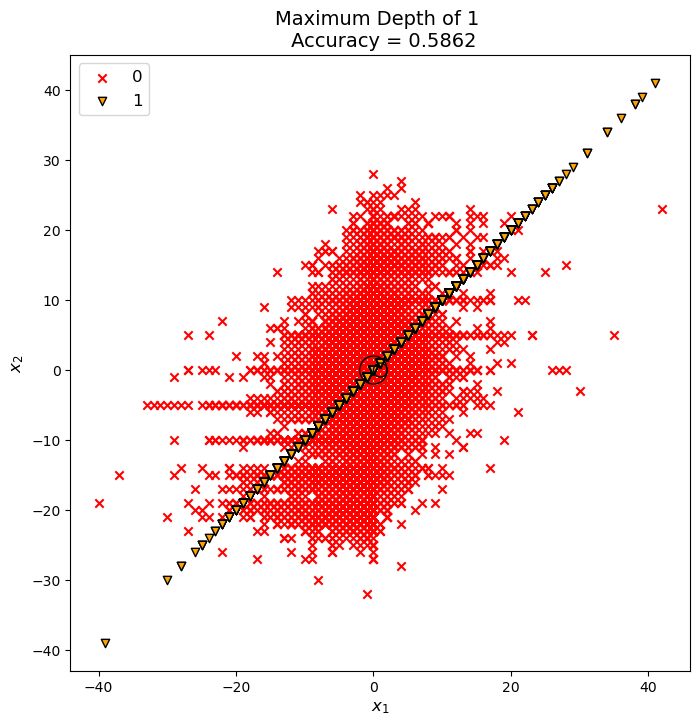

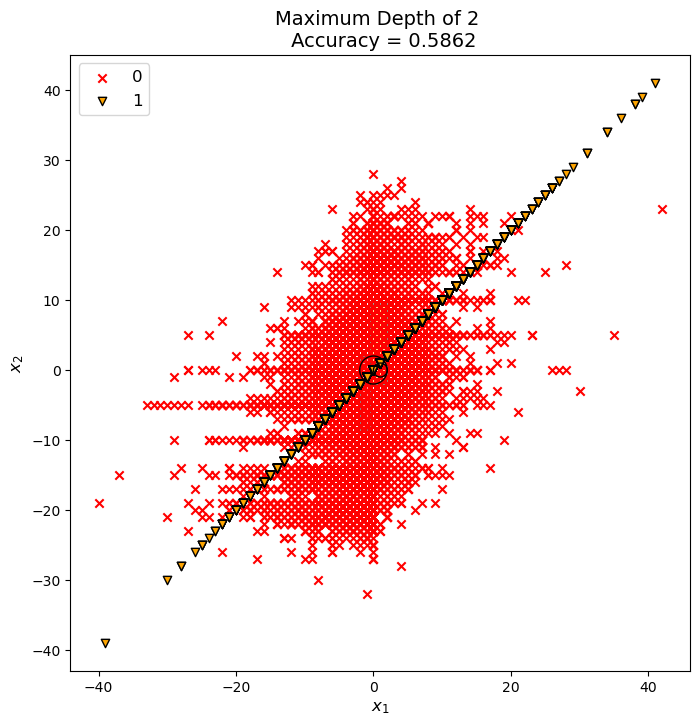

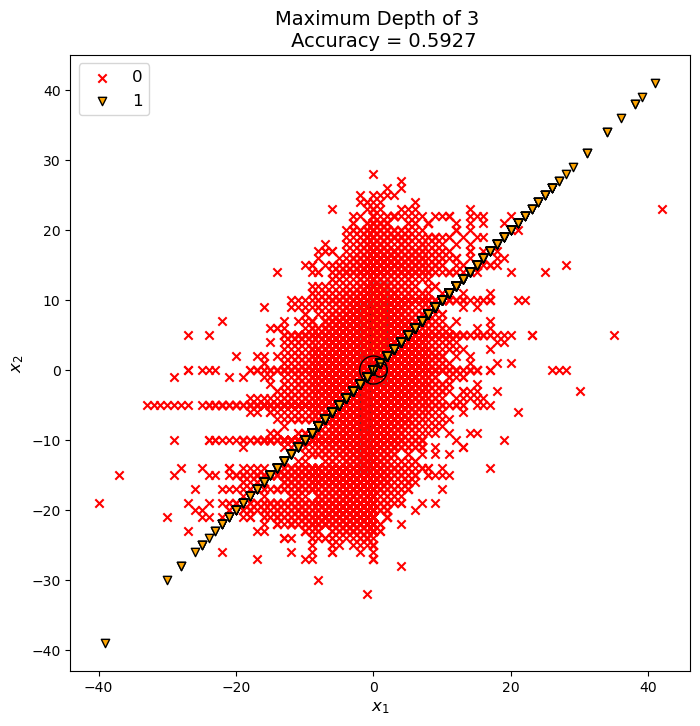

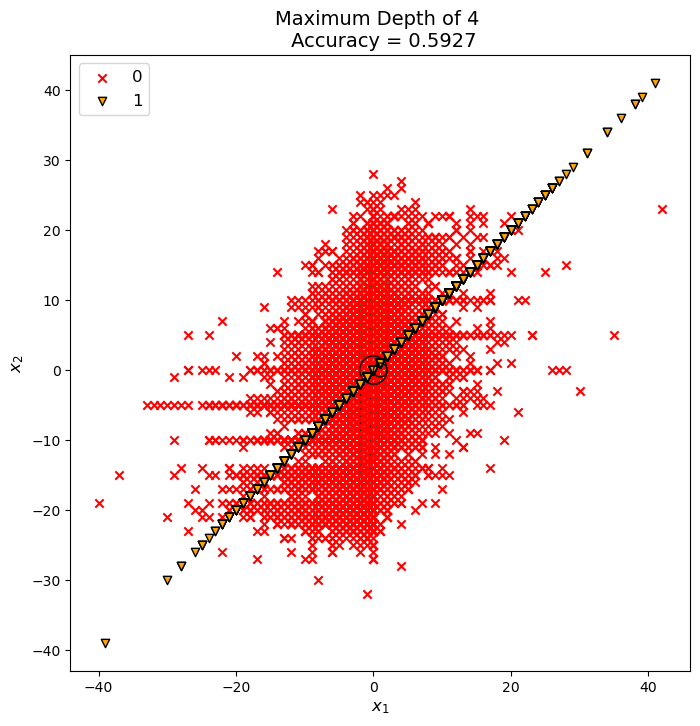

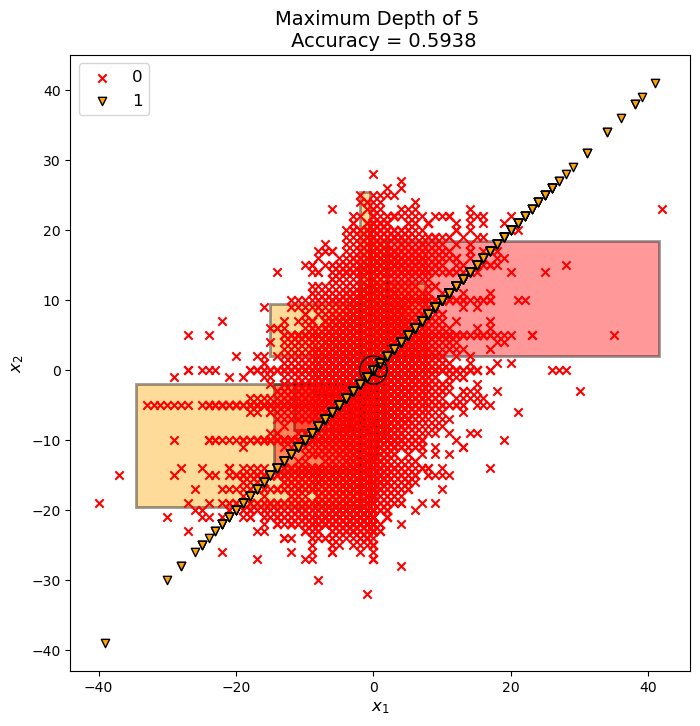

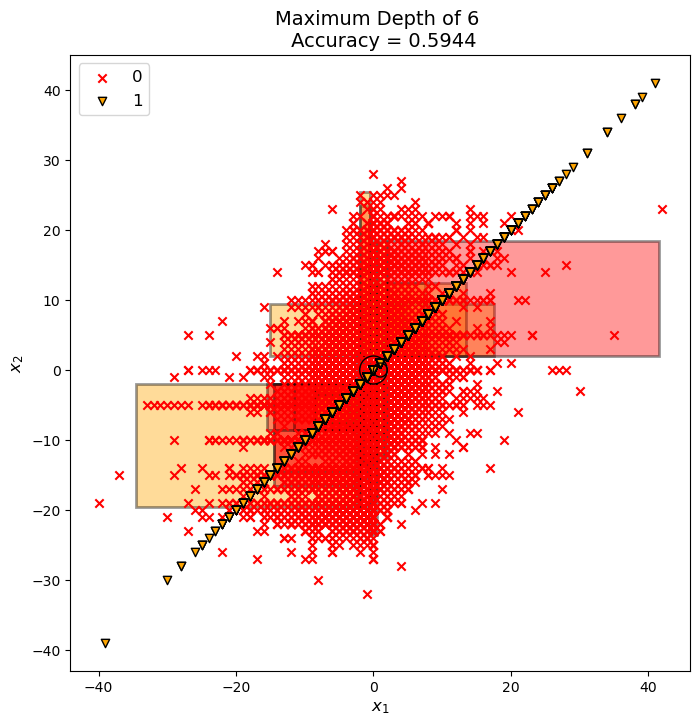

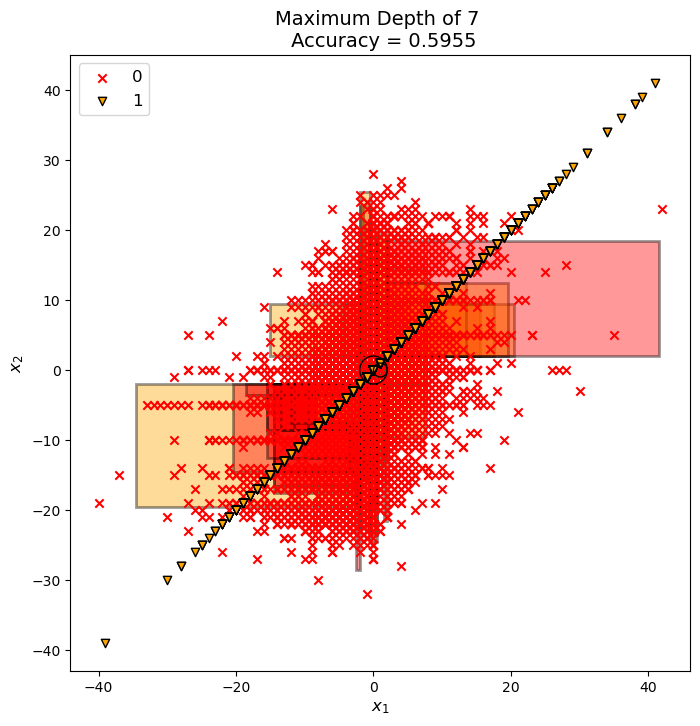

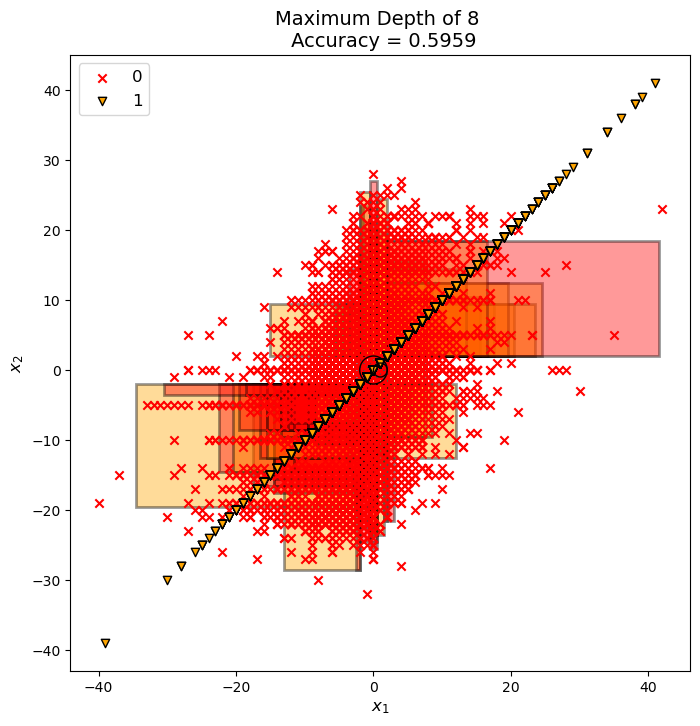

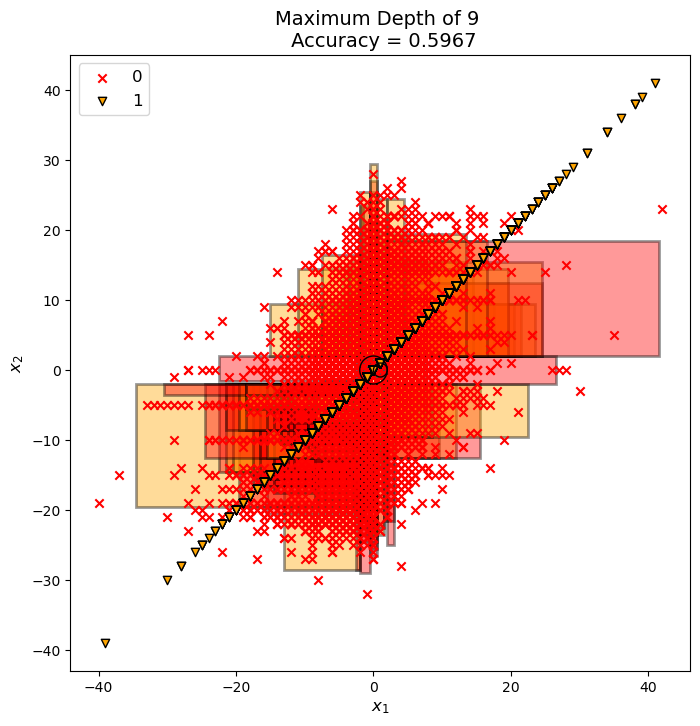

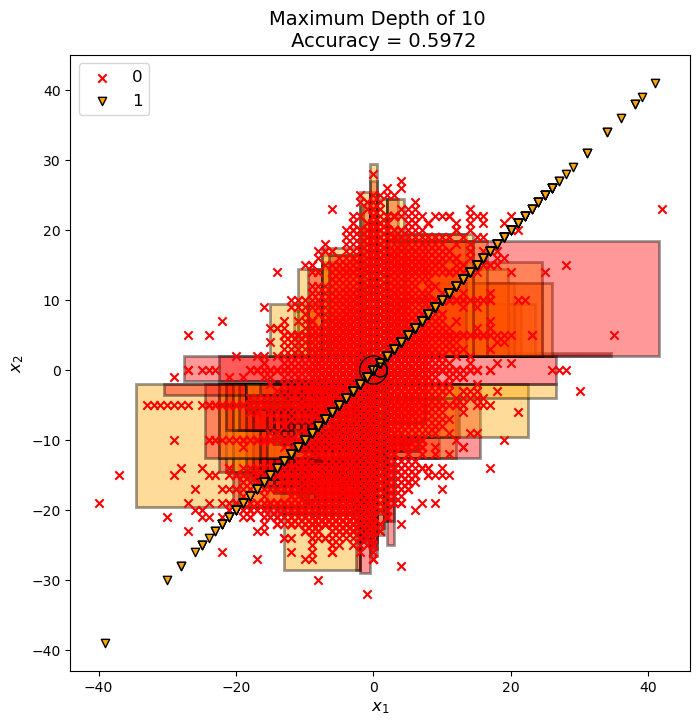

In [50]:
s = 50

for i in range(1,11):
    tree_clf = DecisionTreeClassifier(max_depth  = i, random_state= 216)
    
    tree_clf.fit(sumo_train[features], sumo_train.rikishi1_win)
    
    accuracy = accuracy_score(sumo_train.rikishi1_win, tree_clf.predict(sumo_train[features]))

    plt.figure(figsize=(8,8))
    

    nodes = traversable_nodes(tree_clf)

    for node in nodes.values():
        if node.leaf:
            (xmin,ymin),(xmax,ymax) = node.find_constraints()
            xmin = np.max([xmin,-2])
            xmax = np.min([xmax,2])
            ymin = np.max([ymin,-2])
            ymax = np.min([ymax,2])
            def add_patch(face_color):
                plt.gca().add_patch(
                    patches.Rectangle(
                        (xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='k', facecolor = face_color, zorder = -2, alpha = 0.4)
                    )
            if node.pred == 0:
                add_patch('red')
            elif node.pred == 1:
                add_patch('orange')

    plt.scatter(sumo_train[sumo_train.rikishi1_win == 0]['prev_history'], sumo_train[sumo_train.rikishi1_win == 0]['rank_difference'], c = 'red', marker = 'x', label = "0")
    plt.scatter(sumo_train[sumo_train.rikishi1_win == 1]['prev_history'], sumo_train[sumo_train.rikishi1_win == 1]['prev_history'], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
    plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
    plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

    plt.title(f"Maximum Depth of {i} \n Accuracy = {accuracy:.4f}", fontsize=14)
    plt.xlabel("$x_1$", fontsize=12)
    plt.ylabel("$x_2$", fontsize=12)
    plt.legend(fontsize=12)

    plt.show()


## Random Forests

In [51]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [52]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=50, cv=3, n_jobs=-1, random_state=42)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)
print("Best parameters:", random_search.best_params_)

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 19, 'min_samples_split': 13, 'n_estimators': 154}


In [53]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    random_state= 831)

rf = RandomForestClassifier(
    max_depth = 10, 
    max_features = 'sqrt',
    min_samples_leaf = 18, # minimum number of samples in each leaf, to prevent overfitting
    min_samples_split=13,
    n_estimators = 261,
    random_state= 831
    )

# Note:  by default all of the randomness is coming from using a random subset of features, not samples.  
# Since we have only 2 features the default settings are "worthless" for us: all 1000 trees would be identical, 
# and would only use one feature!

et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    random_state = 216 
    )


In [54]:
tree.fit(sumo_train[features], sumo_train.rikishi1_win)

## rf and et may take slightly longer because we are fitting many trees
rf.fit(sumo_train[features], sumo_train.rikishi1_win)
et.fit(sumo_train[features], sumo_train.rikishi1_win)

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

In [55]:
accs = [accuracy_score(sumo_train.rikishi1_win, tree.predict(sumo_train[features])),  accuracy_score(sumo_train.rikishi1_win, rf.predict(sumo_train[features])), accuracy_score(sumo_train.rikishi1_win, et.predict(sumo_train[features]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.598039
rf,0.596602
et,0.597518


In [56]:
rf_score_df = pd.DataFrame({'feature':features,
                            'importance_score': rf.feature_importances_})

print(rf_score_df.sort_values('importance_score',ascending=False))

et_score_df = pd.DataFrame({'feature':features,
                            'importance_score': et.feature_importances_})

print(et_score_df.sort_values('importance_score',ascending=False))

           feature  importance_score
0     prev_history          0.582515
1  rank_difference          0.417485
           feature  importance_score
0     prev_history          0.501413
1  rank_difference          0.498587


## Bagging & Pasting

In [57]:
from sklearn.ensemble import BaggingClassifier

In [58]:
param_dist = {
    'n_estimators': randint(10, 200),
    'max_samples': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'estimator__max_depth': randint(5, 50)
}

random_search = RandomizedSearchCV(BaggingClassifier(estimator=DecisionTreeClassifier()),
                                   param_dist, n_iter=20, cv=3, n_jobs=-1, random_state=42)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)
print("Best parameters:", random_search.best_params_)

Best parameters: {'bootstrap': True, 'estimator__max_depth': 6, 'max_samples': 0.7, 'n_estimators': 47}


In [59]:
# This is bagging since "bootstrap = True".  We are sampling *with* replacement.

bag = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5)   # each model is trained on 25% of the data.


# This is pasting since "bootstrap = False".  We are sampling *without* replacement.

paste = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5) # each model is trained on 25% of the data.




This next step is used to create the background colors to fill in the graph. They're like phantom predictions.

In [60]:
np.random.seed(4933)

X = np.zeros((200,2))
X[:,0] = np.random.random(200)
X[:,1] = np.random.random(200)

y = np.zeros(200)
y[X[:,0]-X[:,1]>=0.1*np.random.standard_normal(200)] = 1

## to show off our decision boundary later
xx1, xx2 = np.meshgrid(np.arange(-40, 40, 5),
                          np.arange(-40, 40, 5))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

In [63]:
bag.fit(sumo_train[features],sumo_train.rikishi1_win)
y_pred_bag = bag.predict(sumo_train[features])

acc = sum(sumo_train.rikishi1_win == y_pred_bag)/len(y_pred_bag)

In [64]:
paste.fit(sumo_train[features],sumo_train.rikishi1_win)
y_pred_paste = paste.predict(sumo_train[features])

acc = sum(sumo_train.rikishi1_win == y_pred_paste)/len(y_pred_paste)

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


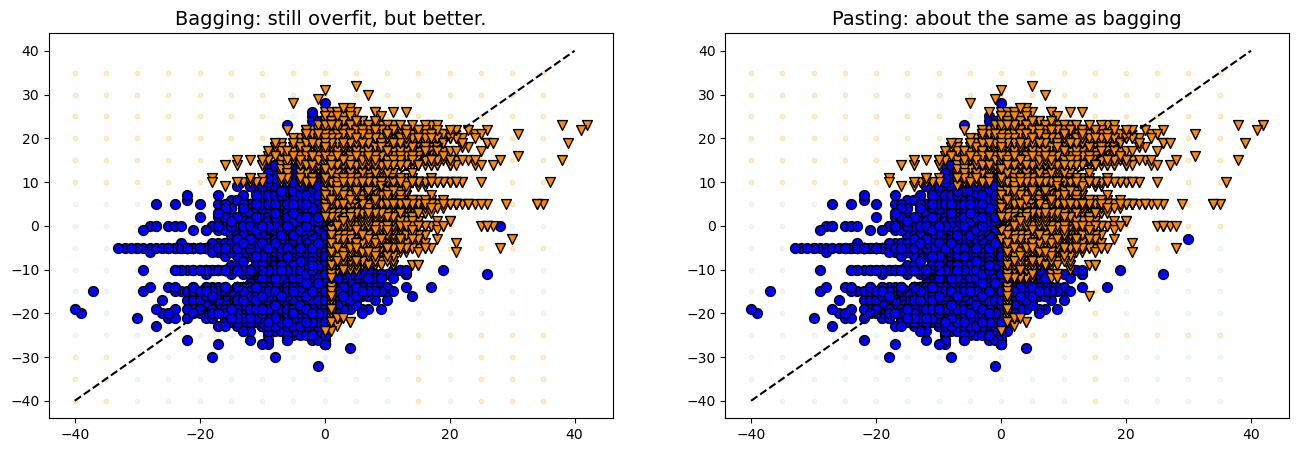

In [65]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

s = 50

ax[0].set_title("Bagging: still overfit, but better.", fontsize=14)

preds_bag = bag.predict(X_pred)
    


ax[0].scatter(X_pred[preds_bag==1,0],
            X_pred[preds_bag==1,1],
            alpha=.2,
            c='orange',
            s=10)
ax[0].scatter(X_pred[preds_bag==0,0],
            X_pred[preds_bag==0,1],
            alpha=.2,
            c='lightblue',
            s=10)

ax[0].scatter(sumo_train[y_pred_bag==0]['prev_history'], 
            sumo_train[y_pred_bag==0]['rank_difference'],
            label='Training 0',
            c = 'blue',
            edgecolor='black',
            s=s)

ax[0].scatter(sumo_train[y_pred_bag==1]['prev_history'], 
            sumo_train[y_pred_bag==1]['rank_difference'],
            label='Training 1',
            c = 'darkorange',
            marker = 'v',
            edgecolor='black',
            s=s)

ax[0].plot([-40,40],[-40,40],'k--')




## Fit Paste Data

ax[1].set_title("Pasting: about the same as bagging", fontsize=14)

preds_paste = paste.predict(X_pred)
    
ax[1].scatter(X_pred[preds_paste==0,0],
            X_pred[preds_paste==0,1],
            alpha=.2,
            c='lightblue',
            s=10)
ax[1].scatter(X_pred[preds_paste==1,0],
            X_pred[preds_paste==1,1],
            alpha=.2,
            c='orange',
            s=10)
ax[1].scatter(sumo_train[y_pred_paste==0]['prev_history'], 
            sumo_train[y_pred_paste==0]['rank_difference'],
            label='Training 0',
            c = 'blue',
            edgecolor='black',
            s=s)

ax[1].scatter(sumo_train[y_pred_paste==1]['prev_history'], 
            sumo_train[y_pred_paste==1]['rank_difference'],
            label='Training 1',
            c = 'darkorange',
            marker = 'v',
            edgecolor='black',
            s=s)

ax[1].plot([-40,40],[-40,40],'k--')

plt.show()


## AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint, uniform

In [67]:
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 5)
}

random_search = RandomizedSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    param_dist,
    n_iter=50,
    cv=3,
    random_state=42,
    n_jobs=-1
)
random_search.fit(sumo_train[features], sumo_train.rikishi1_win)

print("Best parameters:", random_search.best_params_)

/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAM

Best parameters: {'estimator__max_depth': 1, 'learning_rate': np.float64(0.39292687475378985), 'n_estimators': 480}


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


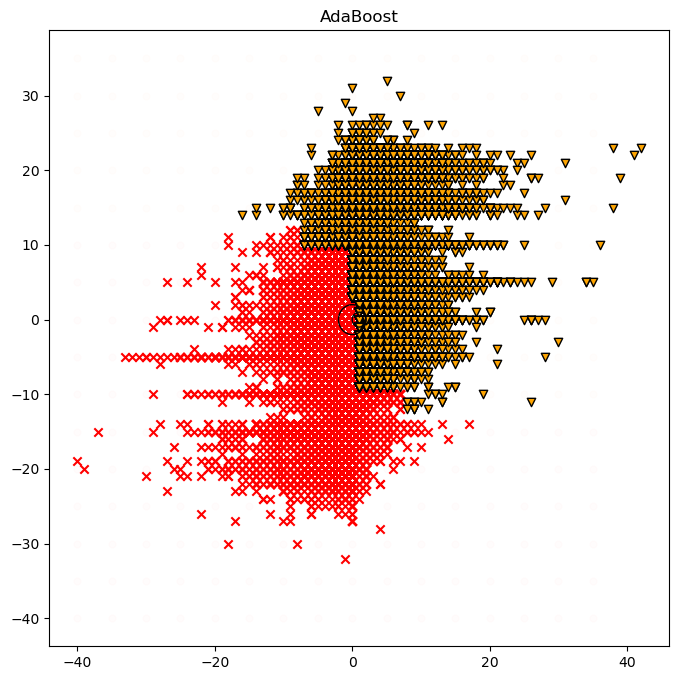

In [68]:


ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                n_estimators=480,
                                algorithm = 'SAMME',
                                learning_rate = 0.39292687475378985,
                                random_state=123)

ada_clf.fit(sumo_train[features], sumo_train.rikishi1_win)
preds = ada_clf.predict(X_pred)
y_preds = ada_clf.predict(sumo_train[features])

s = 25

## this plots the resulting decision boundary ##
plt.figure(figsize=(8,8))
plt.scatter(X_pred[preds==0,0],
            X_pred[preds==0,1],
            alpha=.01,
            c='red',
            s=s)
plt.scatter(X_pred[preds==1,0],
            X_pred[preds==1,1],
            alpha=.01,
            c='orange',
            s=s)

plt.scatter(sumo_train[y_preds == 0]['prev_history'], sumo_train[y_preds == 0]['rank_difference'], c = 'red', marker = 'x', label = "0")
plt.scatter(sumo_train[y_preds == 1]['prev_history'], sumo_train[y_preds == 1]['rank_difference'], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)

plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

plt.title("AdaBoost")
plt.show()

## Voting Classifier

In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [2]:
def logistic_optimal(df, features, y):
    log_reg = LogisticRegression(penalty=None)
    log_reg.fit(df[features], df[[y]])
    y_prob = log_reg.predict_proba(df[features])[:,1]
    y_pred = 1*(y_prob >= .47)
    return y_pred

In [3]:
voting = VotingClassifier([('knn', KNeighborsClassifier(10)),
                               ('log', LogisticRegression(penalty=None)),
                               ('rf', RandomForestClassifier(
                                  max_depth = 10, 
                                  max_features = 'sqrt',
                                  min_samples_leaf = 18, # minimum number of samples in each leaf, to prevent overfitting
                                  min_samples_split=13,
                                  n_estimators = 261,
                                  random_state= 831
                                  )),
                                ('svc', SVC(C = 30.56137691733707, gamma = 0.09867211400638387, kernel = 'rbf')),
                                ('tree', DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf = 7, 
                                  min_samples_split = 12)),
                                  ('bag',BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5)),
                           ('paste', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5)),
                           ('ada_clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                n_estimators=480,
                                algorithm = 'SAMME',
                                learning_rate = 0.39292687475378985,
                                random_state=123))],
                         voting='hard')

Takes 131 minutes to run

Results:
log training set accuracy 0.57249

rf training set accuracy 0.5966 

knn_clf training set accuracy 0.569

svc training set accuracy 0.59573

voting_clf training set accuracy 0.59561

tree training set accuracy 0.59265

bag training set accuracy 0.59585

paste training set accuracy 0.59576

ada_clf training set accuracy 0.59436

log training set accuracy 0.57249


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


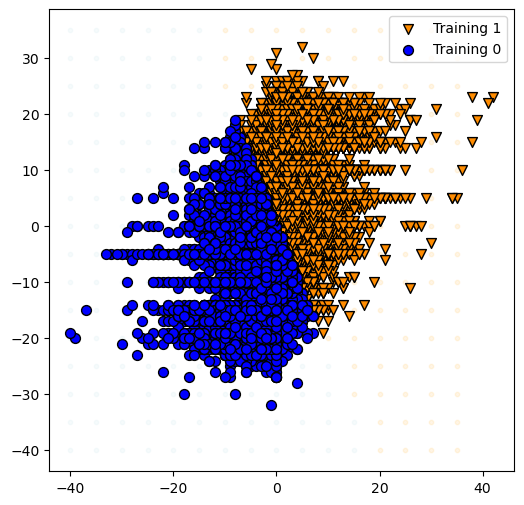



rf training set accuracy 0.5966


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


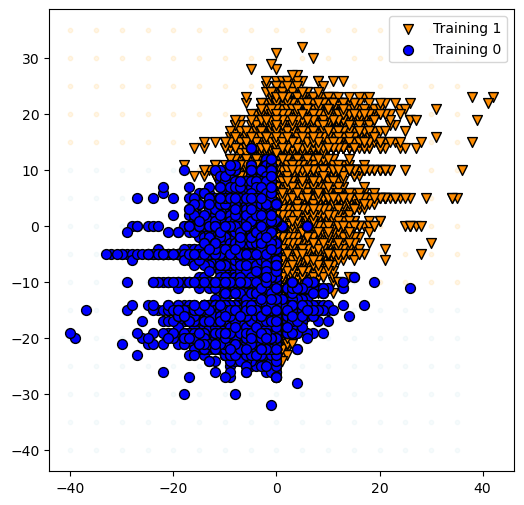



knn_clf training set accuracy 0.569


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


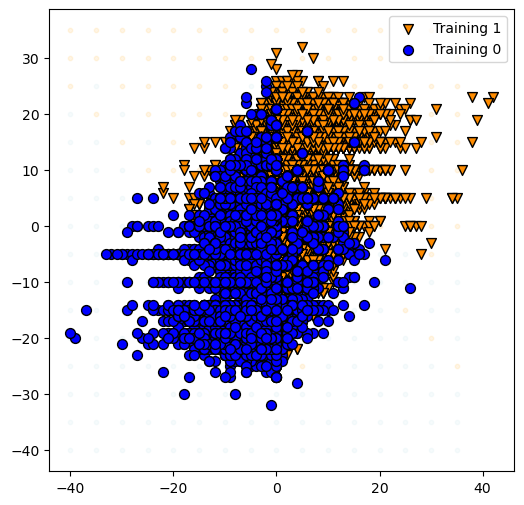



svc training set accuracy 0.59573


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


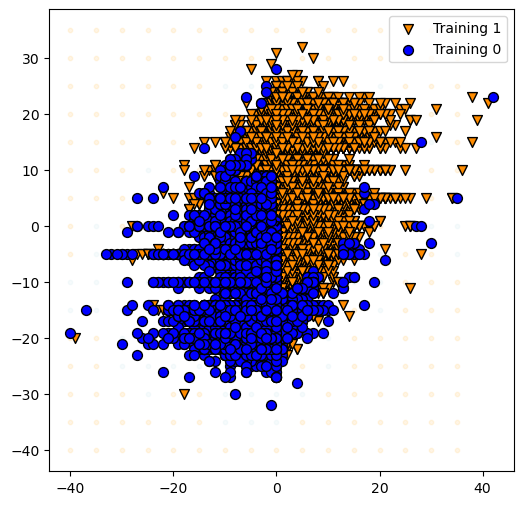



voting_clf training set accuracy 0.59561


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does

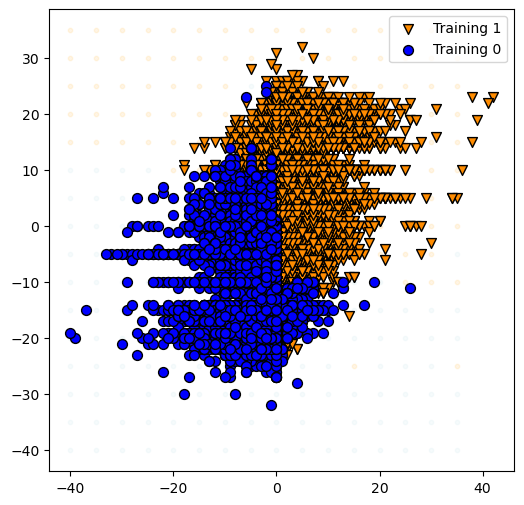



tree training set accuracy 0.59265


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


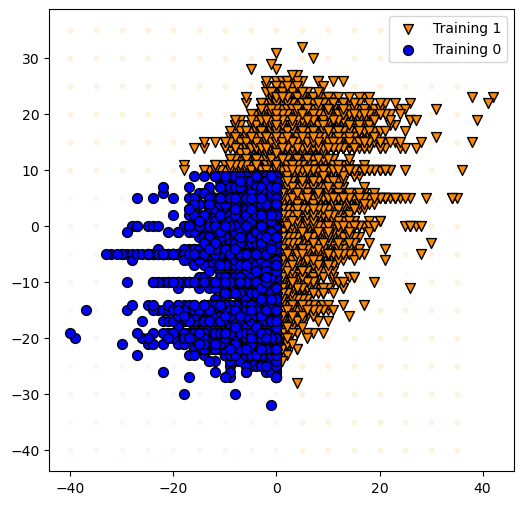



bag training set accuracy 0.59585


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


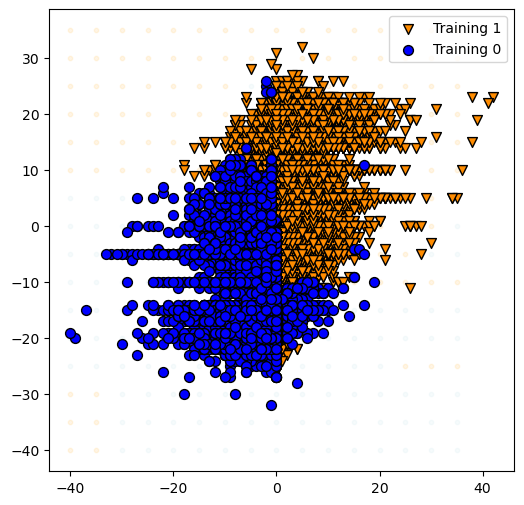



paste training set accuracy 0.59576


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


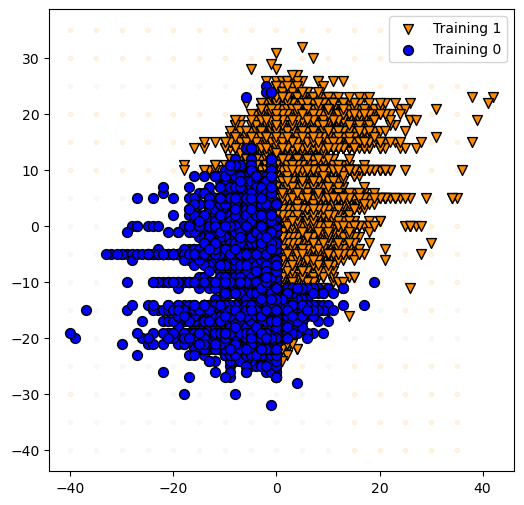



ada_clf training set accuracy 0.59436


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


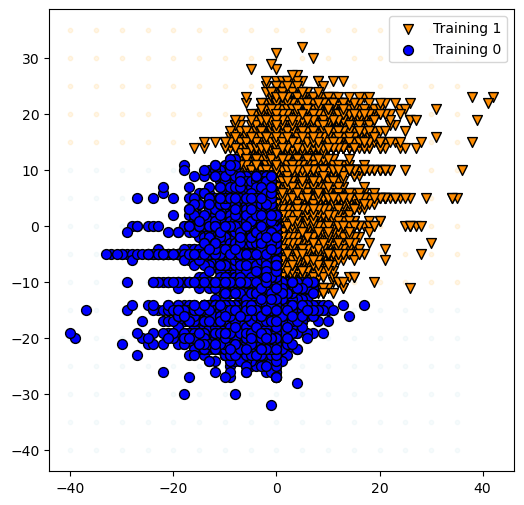

In [44]:
# print each classifier's accuracy

for name,clf in (["log",LogisticRegression(penalty=None)],["rf",RandomForestClassifier(
                                  max_depth = 10, 
                                  max_features = 'sqrt',
                                  min_samples_leaf = 18, # minimum number of samples in each leaf, to prevent overfitting
                                  min_samples_split=13,
                                  n_estimators = 261,
                                  random_state= 831
                                  )],
                 ["knn_clf",KNeighborsClassifier(10)],
                 ['svc', SVC(C = 30.56137691733707, gamma = 0.09867211400638387, kernel = 'rbf')],["voting_clf",voting],
                 ['tree', DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf = 7, 
                                  min_samples_split = 12)],['bag', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5)],
                 ['paste', BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60, # we are making 200 different SVC models
                           max_samples = 0.5)],['ada_clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                n_estimators=480,
                                algorithm = 'SAMME',
                                learning_rate = 0.39292687475378985,
                                random_state=123)]):
    # fit the model
    clf.fit(sumo_train[features], sumo_train.rikishi1_win)
    
    # predict
    y_pred = clf.predict(sumo_train[features])
    
    # get acc
    acc = sum(sumo_train.rikishi1_win == y_pred)/len(y_pred)
    
    print(name,"training set accuracy",np.round(acc,5))
    preds = clf.predict(X_pred)
    
    plt.figure(figsize=(6,6))
    
    
    plt.scatter(X_pred[preds==1,0],
                X_pred[preds==1,1],
                alpha=.1,
                c='orange',
                s=10)
    plt.scatter(X_pred[preds==0,0],
                X_pred[preds==0,1],
                alpha=.1,
                c='lightblue',
                s=10)

    plt.scatter(sumo_train[y_pred==1]['prev_history'], 
                sumo_train[y_pred==1]['rank_difference'],
                label='Training 1',
                c = 'darkorange',
                marker='v',
                edgecolor='black',
                s=50)
    plt.scatter(sumo_train[y_pred==0]['prev_history'], 
                sumo_train[y_pred==0]['rank_difference'],
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=50)
    plt.plot([0,1],
             [0,1],
             'k--')
    
    plt.legend(fontsize=10)
    
    plt.show()
    print()
    print()

# Comparing the Models

In [10]:
classifiers = {
    'lda' : LinearDiscriminantAnalysis(),
    'log_reg' : LogisticRegression(),
     'svc_linear' : LinearSVC(C=7.33, max_iter=1000, dual = True),
    'qda' : QuadraticDiscriminantAnalysis(),
    'lda_poly' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('lda', LinearDiscriminantAnalysis())]),
    'log_reg_poly' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('log_reg', LogisticRegression(penalty=None, max_iter= 100000))]),
    'gnb' : GaussianNB(var_smoothing=1e-12),
    'knn' : Pipeline([('scale', StandardScaler()),('knn', KNeighborsClassifier(55))]),   
    'svc_rbf' : Pipeline([('scale', StandardScaler()),('svc',SVC(C = 30.56137691733707, gamma = 0.09867211400638387, kernel = 'rbf'))]),
    'tree_clf': DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf = 7, 
                                  min_samples_split = 12),
    'rf': RandomForestClassifier(
                                  max_depth = 10, 
                                  max_features = 'sqrt',
                                  min_samples_leaf = 18, # minimum number of samples in each leaf, to prevent overfitting
                                  min_samples_split=13,
                                  n_estimators = 261,
                                  random_state= 831
                                  ),
    'bag': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60,
                           max_samples = 0.5),
    'paste': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 7),
                           bootstrap = True,
                           n_estimators = 60,
                           max_samples = 0.5),
    'ada_clf': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
        n_estimators=480,
        algorithm = 'SAMME',
        learning_rate = 0.39292687475378985,
        random_state=123),
    'voting': voting
}

In [11]:
scores = {}

for name in classifiers.keys():
    clf = classifiers[name]
    print(clf)
    clf.fit(sumo_train[features], sumo_train.rikishi1_win)
    
    y_pred = clf.predict(sumo_train[features])
    
    acc = accuracy_score(sumo_train.rikishi1_win,y_pred)
    rec = recall_score(sumo_train.rikishi1_win, y_pred)
    prec = precision_score(sumo_train.rikishi1_win, y_pred)
    roc = roc_auc_score(sumo_train.rikishi1_win, y_pred)

    scores[name] = {'accuracy_score': acc,
                    'recall_score': rec,
                    'precision_score': prec,
                    'roc_auc_score': roc}

print(scores)

LinearDiscriminantAnalysis()
LogisticRegression()
LinearSVC(C=7.33, dual=True)


/Users/greysonmeyer/miniconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


QuadraticDiscriminantAnalysis()
Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lda', LinearDiscriminantAnalysis())])
Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures()),
                ('log_reg', LogisticRegression(max_iter=100000, penalty=None))])
GaussianNB(var_smoothing=1e-12)
Pipeline(steps=[('scale', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=55))])
Pipeline(steps=[('scale', StandardScaler()),
                ('svc', SVC(C=30.56137691733707, gamma=0.09867211400638387))])
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=7,
                       min_samples_split=12)
RandomForestClassifier(max_depth=10, min_samples_leaf=18, min_samples_split=13,
                       n_estimators=261, random_state=831)
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7),
                  max_samples=0.5, n_estimators=60)
BaggingClassifier(estimator=Decisi

In [5]:
score_dict = {'lda': {'accuracy_score': 0.5708898079948327, 
                      'recall_score': np.float64(0.5560855677901992), 
                      'precision_score': np.float64(0.5687665226642594), 
                      'roc_auc_score': np.float64(0.5707657740395241)}, 
            'log_reg': {'accuracy_score': 0.5724941919218227, 
                        'recall_score': np.float64(0.5574934857527107), 
                        'precision_score': np.float64(0.570451759950115), 
                        'roc_auc_score': np.float64(0.5723685119211703)}, 
            'svc_linear': {'accuracy_score': 0.560325877462573, 
                           'recall_score': np.float64(0.6001723123476507), 
                           'precision_score': np.float64(0.5520420588746932), 
                           'roc_auc_score': np.float64(0.5606597217433619)}, 
            'qda': {'accuracy_score': 0.573994395074333, 
                    'recall_score': np.float64(0.5745566109103135), 
                    'precision_score': np.float64(0.5697793152312085), 
                    'roc_auc_score': np.float64(0.5739991054716861)}, 
            'lda_poly': {'accuracy_score': 0.5711294237761364, 
                        'recall_score': np.float64(0.5585861982012272), 
                        'precision_score': np.float64(0.5686962474862008), 
                        'roc_auc_score': np.float64(0.571024333217021)}, 
            'log_reg_poly': {'accuracy_score': 0.5721191411336952, 
                             'recall_score': np.float64(0.5645120618643356), 
                             'precision_score': np.float64(0.5690199317955561),
                             'roc_auc_score': np.float64(0.5720554069523335)}, 
            'gnb': {'accuracy_score': 0.573921468532197, 
                    'recall_score': np.float64(0.5873119273766496), 
                    'precision_score': np.float64(0.5679767517476833), 
                    'roc_auc_score': np.float64(0.5740336574423279)}, 
            'knn': {'accuracy_score': 0.5878296019252607, 
                    'recall_score': np.float64(0.5498655123140287), 
                    'precision_score': np.float64(0.5905572231375116), 
                    'roc_auc_score': np.float64(0.587511528445698)}, 
            'svc_rbf': {'accuracy_score': 0.592715680248367, 
                        'recall_score': np.float64(0.5681054047238799), 
                        'precision_score': np.float64(0.593185009654204), 
                        'roc_auc_score': np.float64(0.5925094886591775)}, 
            'tree_clf': {'accuracy_score': 0.592653171783679, 
                         'recall_score': np.float64(0.47354375052534253), 
                         'precision_score': np.float64(0.6160133398939369), 
                         'roc_auc_score': np.float64(0.5916552406214597)}, 
            'rf': {'accuracy_score': 0.5966016231364664, 
                   'recall_score': np.float64(0.6037446415062621), 
                   'precision_score': np.float64(0.5912336660150221), 
                   'roc_auc_score': np.float64(0.5966614692892579)}, 
            'bag': {'accuracy_score': 0.5962057361934429, 
                    'recall_score': np.float64(0.6459191392788097), 
                    'precision_score': np.float64(0.5838509316770186), 
                    'roc_auc_score': np.float64(0.5966222486203756)}, 
            'paste': {'accuracy_score': 0.5962161542708908, 
                      'recall_score': np.float64(0.6458981255778767), 
                      'precision_score': np.float64(0.5838652078109566), 
                      'roc_auc_score': np.float64(0.5966324033538262)}, 
            'ada_clf': {'accuracy_score': 0.594361736485149, 
                        'recall_score': np.float64(0.5474909641085988), 
                        'precision_score': np.float64(0.5995489690721649), 
                        'roc_auc_score': np.float64(0.5939690403922816)}, 
            'voting': {'accuracy_score': 0.5956223238563555, 
                       'recall_score': np.float64(0.5741153231907203), 
                       'precision_score': np.float64(0.5956310362118207), 
                       'roc_auc_score': np.float64(0.5954421323488881)}}

mean_dict = {}

for model in score_dict:
    metrics = score_dict[model]
    mean_score = sum(0.25 * value for value in metrics.values())
    mean_dict[model] = mean_score

best_model = max(mean_dict, key=mean_dict.get)
print(f"The best model is {best_model} with a score of {mean_dict[best_model]:.4f}.")

The best model is paste with a score of 0.6057.


## The rest are experimental comparisons between specific models that were done similarly in The Erdos Institute Lectures.

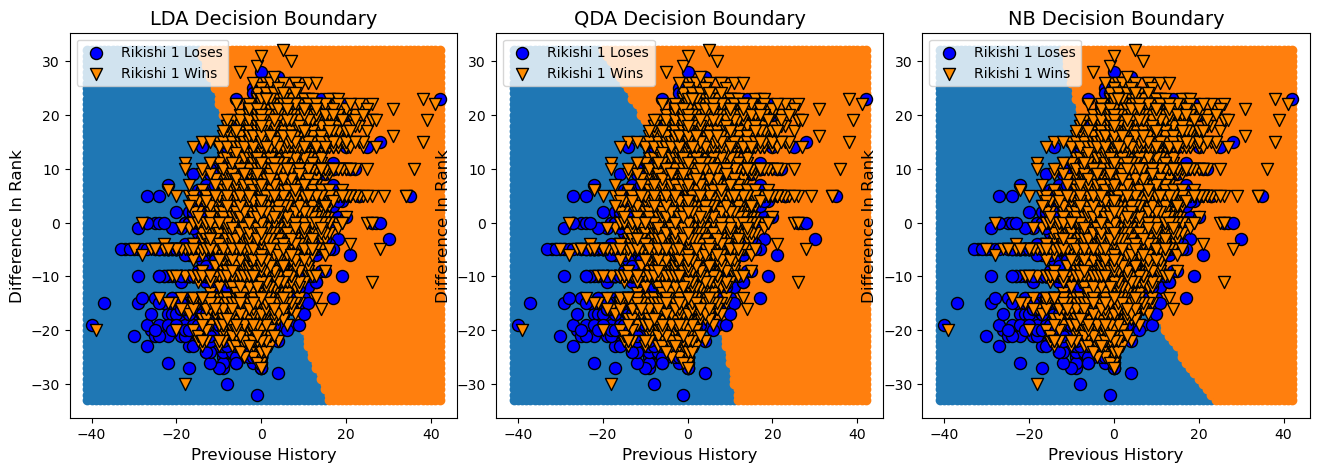

In [39]:
p_width_min, p_width_max = sumo_train.prev_history.min()-1, sumo_train.prev_history.max()+1
p_length_min, p_length_max = sumo_train.rank_difference.min()-1, sumo_train.rank_difference.max()+1

xx1, xx2 = np.meshgrid(np.arange(p_width_min, p_width_max, 1),
                          np.arange(p_length_min, p_length_max, 1))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

LDA_preds = LDA.predict(X_pred)
QDA_preds = QDA.predict(X_pred)
NB_preds = nb.predict(X_pred)


## plotting the decision boundary with the training points
fig,ax = plt.subplots(1,3, figsize=(16,5))


## LDA first
### Decision Boundaries
ax[0].scatter(X_pred[LDA_preds==0,0],
            X_pred[LDA_preds==0,1],
            alpha=1)
ax[0].scatter(X_pred[LDA_preds==1,0],
            X_pred[LDA_preds==1,1],
            alpha=1)

### Training Points
ax[0].scatter(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference,
                label='Rikishi 1 Loses',
                c = 'blue',
                edgecolor='black',
                s=75)
ax[0].scatter(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference,
                label='Rikishi 1 Wins',
                marker='v',
                c = 'darkorange',
                edgecolor='black',
                s=75)

ax[0].set_title("LDA Decision Boundary", fontsize=14)
ax[0].set_xlabel("Previouse History", fontsize=12)
ax[0].set_ylabel("Difference In Rank", fontsize=12)



## QDA second
### Decision Boundaries
ax[1].scatter(X_pred[QDA_preds==0,0],
            X_pred[QDA_preds==0,1],
            alpha=1)
ax[1].scatter(X_pred[QDA_preds==1,0],
            X_pred[QDA_preds==1,1],
            alpha=1)

### Training Points
ax[1].scatter(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference,
                label='Rikishi 1 Loses',
                c = 'blue',
                edgecolor='black',
                s=75)
ax[1].scatter(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference,
                label='Rikishi 1 Wins',
                c = 'darkorange',
                marker='v',
                edgecolor='black',
                s=75)

ax[1].set_title("QDA Decision Boundary", fontsize=14)
ax[1].set_xlabel("Previous History", fontsize=12)
ax[1].set_ylabel("Difference In Rank", fontsize=12)

ax[2].scatter(X_pred[NB_preds==0,0],
            X_pred[NB_preds==0,1],
            alpha=1)
ax[2].scatter(X_pred[NB_preds==1,0],
            X_pred[NB_preds==1,1],
            alpha=1)
ax[2].scatter(X_pred[NB_preds==2,0],
            X_pred[NB_preds==2,1],
            c = 'lightgreen',
            alpha=1)

### Training data
ax[2].scatter(sumo_train.loc[sumo_train.rikishi1_win==0].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==0].rank_difference,
                label='Rikishi 1 Loses',
                c = 'blue',
                edgecolor='black',
                s=75)
ax[2].scatter(sumo_train.loc[sumo_train.rikishi1_win==1].prev_history, 
                sumo_train.loc[sumo_train.rikishi1_win==1].rank_difference,
                label='Rikishi 1 Wins',
                c = 'darkorange',
                marker = 'v',
                edgecolor='black',
                s=75)

ax[2].set_title("NB Decision Boundary", fontsize=14)
ax[2].set_xlabel("Previous History", fontsize=12)
ax[2].set_ylabel("Difference In Rank", fontsize=12)




ax[0].legend(fontsize=10, loc=2)
ax[1].legend(fontsize=10, loc=2)
ax[2].legend(fontsize=10, loc=2)

plt.subplots_adjust(wspace=.1)


plt.show()

In [40]:
# The mean of each class.  These should be identical.

LDA.means_, QDA.means_, nb.theta_

(array([[-0.63931073, -0.99719002],
        [ 0.55621165,  1.32201395]]),
 array([[-0.63931073, -0.99719002],
        [ 0.55621165,  1.32201395]]),
 array([[-0.63931073, -0.99719002],
        [ 0.55621165,  1.32201395]]))

In [43]:
print("LDA common covariance matrix \n")
print(LDA.covariance_, '\n')

print("QDA covariance matrix for each class \n")
print("Class 0")
print(QDA.covariance_[0], '\n')
print("Class 1")
print(QDA.covariance_[1], '\n')
print("Class 2")

print("NB variance for feature and each class \n")
print(nb.var_)

LDA common covariance matrix 

[[11.53240628  7.19808473]
 [ 7.19808473 46.49141109]] 

QDA covariance matrix for each class 

Class 0
[[11.67797114  7.53582682]
 [ 7.53582682 46.89110331]] 

Class 1
[[11.38484531  6.85488921]
 [ 6.85488921 46.08686108]] 

Class 2
NB variance for feature and each class 

[[11.67772991 46.89013451]
 [11.38460612 46.08589267]]


In [19]:
for model_name, model in classifiers.items():
    model.fit(sumo_train[features], sumo_train.rikishi1_win)

accs = {model_name: accuracy_score(sumo_test.rikishi1_win, model.predict(sumo_test[features])) for model_name, model in classifiers.items()}

accs

{'lda': 0.5763172698293644,
 'log_reg': 0.578192387024189,
 'svc_linear': 0.5768798049878118,
 'qda': 0.5787549221826365,
 'lda_poly': 0.5764110256891055,
 'log_reg_poly': 0.5766922932683293,
 'gnb': 0.5771610725670354,
 'knn': 0.5390024376523532,
 'svc_rbf': 0.6040690043127696}

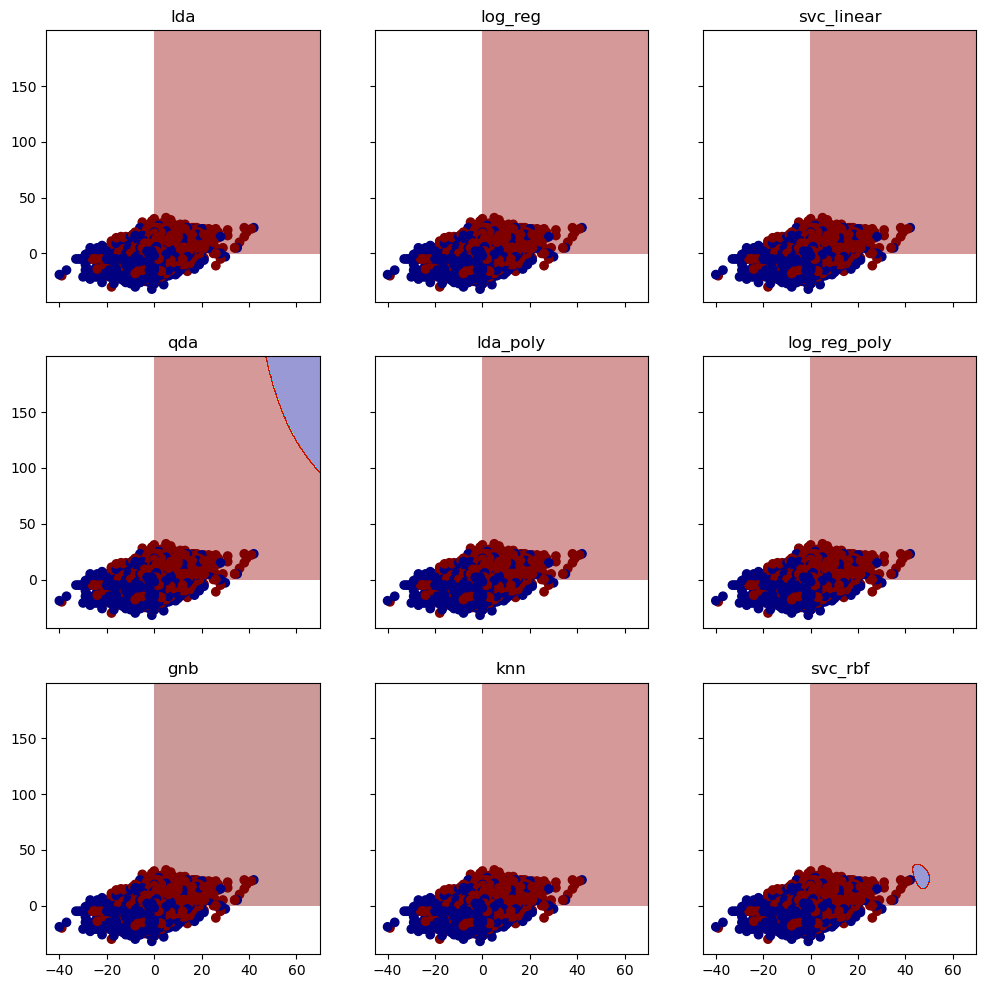

In [20]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))

xx, yy = np.mgrid[0:70:.1, 0:200:.1]

grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['prev_history','rank_difference'])

for i,(model_name,model) in enumerate(classifiers.items()):
    preds = model.predict(grid).reshape(xx.shape)
    indices = divmod(i, 3)
    contour = axs[indices].contourf(xx, yy, preds, 25, alpha = 0.4,
                      vmin=0, vmax=1, cmap=plt.cm.jet)

    axs[indices].scatter(sumo_train['prev_history'], sumo_train['rank_difference'], c = sumo_train.rikishi1_win, cmap=plt.cm.jet)
    axs[indices].title.set_text(model_name)

plt.show()